# Human Pose Estimation with MoveNet

## Visualization libraries & Imports

In [35]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import time
# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [36]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

## Load Model from TF hub

In [37]:
# model_name = "movenet_lightning" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

# if "tflite" in model_name:
#   if "movenet_lightning_f16" in model_name:
#     !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
#     input_size = 192
#   elif "movenet_thunder_f16" in model_name:
#     !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
#     input_size = 256
#   elif "movenet_lightning_int8" in model_name:
#     !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
#     input_size = 192
#   elif "movenet_thunder_int8" in model_name:
#     !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
#     input_size = 256
#   else:
#     raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_path="lite-model_movenet_singlepose_lightning_3.tflite")
interpreter.allocate_tensors()
input_size = 192
def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.float32)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

# else:
#     if "movenet_lightning" in model_name:
# module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
# input_size = 192
#     elif "movenet_thunder" in model_name:
#         module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
#         input_size = 256
#     else:
#         raise ValueError("Unsupported model name: %s" % model_name)

# def movenet(input_image):
#     """Runs detection on an input image.

#     Args:
#       input_image: A [1, height, width, 3] tensor represents the input image
#         pixels. Note that the height/width should already be resized and match the
#         expected input resolution of the model before passing into this function.

#     Returns:
#       A [1, 1, 17, 3] float numpy array representing the predicted keypoint
#       coordinates and scores.
#     """
#     model = module.signatures['serving_default']

#     # SavedModel format expects tensor type of int32.
#     input_image = tf.cast(input_image, dtype=tf.int32)
#     # Run model inference.
#     outputs = model(input_image)
#     # Output is a [1, 1, 17, 3] tensor.
#     keypoints_with_scores = outputs['output_0']
#     return keypoints_with_scores

In [38]:
#@title Cropping Algorithm

# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.1

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inferece on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores

### Load Input Image Sequence

In [39]:
# Load the input image.
image_path = 'yoga.gif'
image = tf.io.read_file(image_path)
image = tf.image.decode_gif(image)

### Run Inference with Cropping Algorithm

KeyboardInterrupt: 

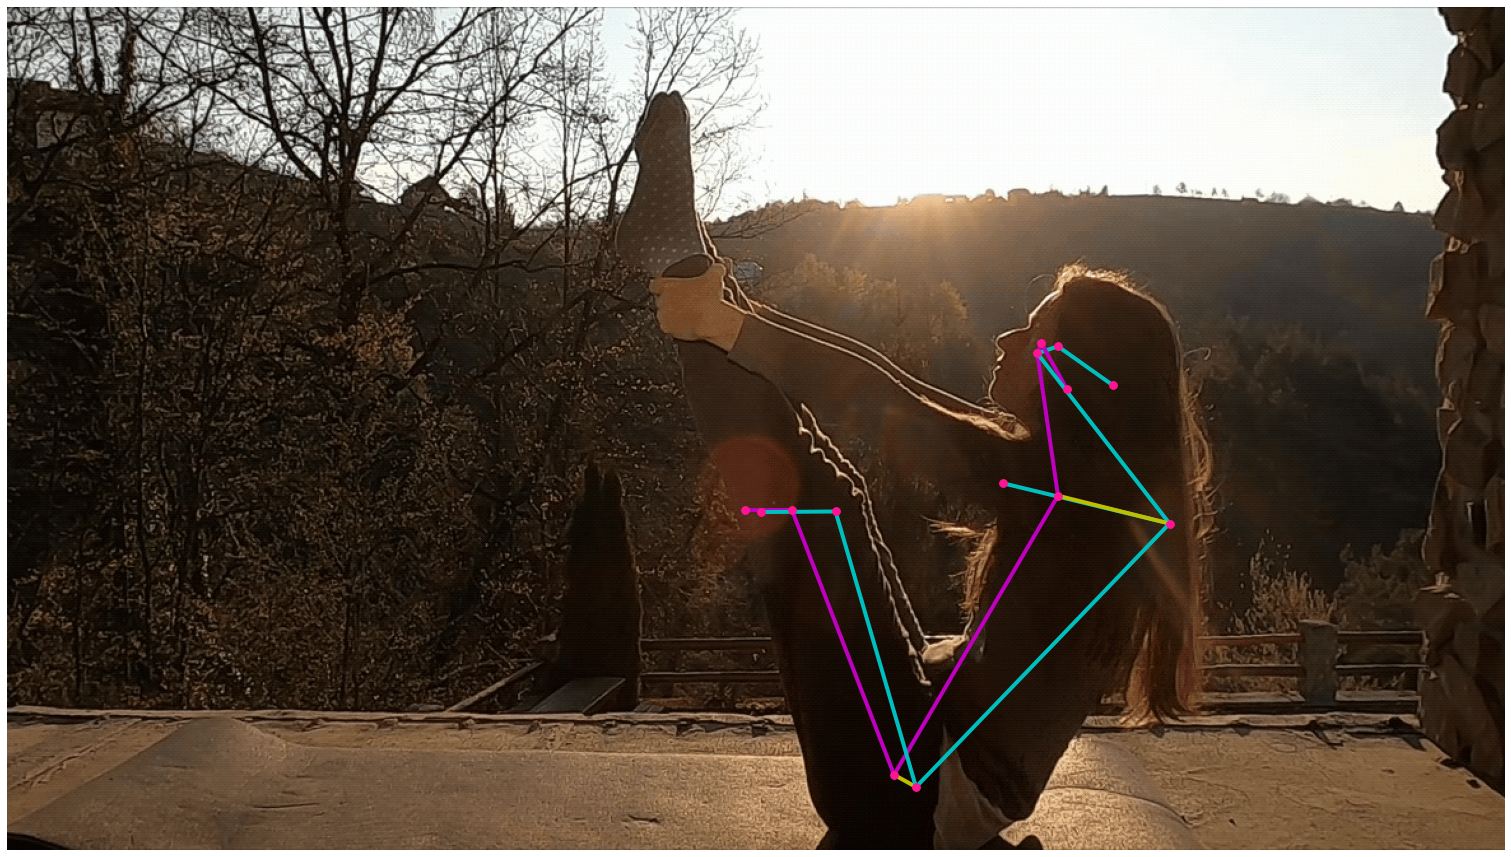

In [40]:

# Load the input image.
num_frames, image_height, image_width, _ = image.shape
crop_region = init_crop_region(image_height, image_width)

output_images = []
bar = display(progress(0, num_frames-1), display_id=True)
for frame_idx in range(num_frames):
  keypoints_with_scores = run_inference(
      movenet, image[frame_idx, :, :, :], crop_region,
      crop_size=[input_size, input_size])
  output_images.append(draw_prediction_on_image(
      image[frame_idx, :, :, :].numpy().astype(np.int32),
      keypoints_with_scores, crop_region=None,
      close_figure=True, output_image_height=300))
  crop_region = determine_crop_region(
      keypoints_with_scores, image_height, image_width)
  bar.update(progress(frame_idx, num_frames-1))

# Prepare gif visualization.
output = np.stack(output_images, axis=0)
to_gif(output, fps=10)

In [41]:
def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)

In [42]:
KEYPOINT_DICT = {
        "nose": 0,
        "left_eye": 1,
        "right_eye": 2,
        "left_ear": 3,
        "right_ear": 4,
        "left_shoulder": 5,
        "right_shoulder": 6,
        "left_elbow": 7,
        "right_elbow": 8,
        "left_wrist": 9,
        "right_wrist": 10,
        "left_hip": 11,
        "right_hip": 12,
        "left_knee": 13,
        "right_knee": 14,
        "left_ankle": 15,
        "right_ankle": 16,
    }

    # Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
        (0, 1): (255, 0, 255),
        (0, 2): (0, 255, 255),
        (1, 3): (255, 0, 255),
        (2, 4): (0, 255, 255),
        (0, 5): (255, 0, 255),
        (0, 6): (0, 255, 255),
        (5, 7): (255, 0, 255),
        (7, 9): (255, 0, 255),
        (6, 8): (0, 255, 255),
        (8, 10): (0, 255, 255),
        (5, 6): (255, 255, 0),
        (5, 11): (255, 0, 255),
        (6, 12): (0, 255, 255),
        (11, 12): (255, 255, 0),
        (11, 13): (255, 0, 255),
        (13, 15): (255, 0, 255),
        (12, 14): (0, 255, 255),
        (14, 16): (0, 255, 255),
    }

In [43]:
def draw_keypoints(frame, keypoints, confidence_threshold=0.2):
    """
    Method to draw the appropriate keypoints for each frame
    """
    # Get the dimensions of the frame
    y, x, _ = frame.shape
    # Normalizing the Keypoint Coordinates according to the image size
    new_keypoints = np.squeeze(np.multiply(keypoints, np.array([y, x, 1])))
    # print(new_keypoints)
    for keypoint in new_keypoints:
        # Getting the coordinates and the confidence coordinates for each keypoint
        ky, kx, kp_conf = keypoint
        # if the confidence score is less than the threshold, just ignore the keypoint detection altogether.
        if kp_conf > confidence_threshold:
            # Draw a circle filled with green color at the keypoint location with a radius of 3
            cv2.circle(frame, (int(kx), int(ky)), 4, (0, 255, 0), -1)


def draw_connections(frame, keypoints, edges, confidence_threshold=0.1):
    """
    Method to draw the edges between the appropriate keypoints for each frame
    """
    # Get the dimensions of the frame
    y, x, _ = frame.shape
    # Normalizing the Keypoint Coordinates according to the image size
    new_keypoints = np.squeeze(np.multiply(keypoints, np.array([y, x, 1])))

    for vertices, edge_color in edges.items():
        # Grab the vertices for a particular edge
        v1, v2 = vertices
        # Get the coordinates and confidence score for first vertex
        y1, x1, c1 = new_keypoints[v1]
        # Get the coordinates and confidence score for second vertex
        y2, x2, c2 = new_keypoints[v2]
        # Check if the confidence score of both vertices is above the required threshold
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):
            # Draw line of width 2 from the first vertex to the second vertex
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), edge_color, 3)


# Inference

In [44]:
import time
time0 = 0
cap = cv2.VideoCapture('yoga-6.mp4')
image_width = int(cap.get(3))
image_height = int(cap.get(4))

crop_region = init_crop_region(image_height, image_width)
seq =[]
while cap.isOpened():
    ret, frame = cap.read()
    frame = rescale_frame(frame, percent=30)
    if ret == True:
        keypoints_with_scores = run_inference(movenet, frame[ :, :, :], crop_region, crop_size=[input_size, input_size])
        draw_keypoints(frame, keypoints_with_scores, confidence_threshold=0.1)
        draw_connections(
            frame, keypoints_with_scores, KEYPOINT_EDGE_INDS_TO_COLOR, 0.1
        )
        crop_region = determine_crop_region(keypoints_with_scores, image_height, image_width)
        seq.append(keypoints_with_scores)
        cv2.imshow("Test", frame)
        time1 = time.time()
        fps = 1 / (time1 - time0)
        time0 = time1
        print(fps)
        if cv2.waitKey(25) & 0xFF == ord("q"):
            break     
# Release video capture object
cap.release()
# Close all windows
cv2.destroyAllWindows()


6.061522614341907e-10
10.336857566750952
9.7292838569152
10.827614870498824
11.303390771453056
8.802704841136755
11.142114085491064
10.408554546650223
10.697271806799952
10.664632549435405
7.618499587679051
10.636101291759013
10.768763094113297
10.31669515809669
11.452462346683559
10.642767426458834
9.049785315122877
10.784739953356938
10.849573317261056
9.60623695957382
10.236576145185815
9.529000686111022
9.952410330394176
10.904209021188093
10.867142361165088
10.55210636879379
10.310760615454203
9.169200365517211
10.186580141251445
11.023601518066462
10.468539252928933
6.716678863852186
10.026424430765553
10.313093039781458
10.862836201649767
10.894437590098573
10.463890468919958
10.648441566024946
11.082145669187316
7.856605795184853
9.891386580384685
11.67975183022425
10.370594547549464
10.562523136897402
10.880532936259847
6.591967309732427
9.41268982789536
11.253260499196445
10.718430326308338
10.837882812580748
10.590179166582503
9.020474175011183
10.80276720358933
10.634779852

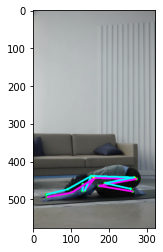

In [33]:
plt.imshow(tf.cast(np.squeeze(frame), dtype=tf.int32))

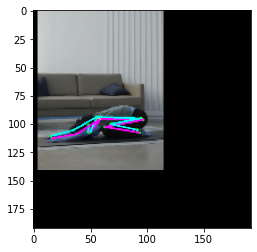

In [34]:
img = frame.copy()
# img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192, 192)
img= np.expand_dims(img, axis=0)
boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
output_image = tf.image.crop_and_resize(img, box_indices=[0], boxes=boxes, crop_size=[192,192])

#plot cropped frame
plt.imshow(tf.cast(np.squeeze(output_image), dtype=tf.int32))

In [15]:
seq_reshaped = np.reshape(seq, (-1,51))

In [16]:
seq_reshaped.shape

(200, 51)

# Save to text file


In [17]:
output_file = "skeleton\yoga.txt"
with open(output_file, 'w') as f:
    for frames in seq_reshaped:
#         frames = np.reshape(frames, (17,3))
        joints = [frames[i * 3:(i + 1) * 3] for i in range((len(frames) + 3 - 1) // 3 )]
        for joint in joints:
#             f.write(f"{joint[0]:4e}\t{joint[1]:4e}\t{joint[2]:4e}\n")
            f.write("%.4e\t%.4e\n" %(joint[0], joint[1]))

In [51]:
sample = np.loadtxt('skeleton\yoga.txt')

In [53]:
sample_reshape = np.reshape(sample, (-1, 17, 3))

In [54]:
sample_reshape.shape

(76, 17, 3)